In [67]:
from pathlib import Path
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib import ticker
import cartopy.crs as ccrs
import numpy as np

plt.rcParams["figure.figsize"] = (20, 20)
plt.rcParams["figure.facecolor"] = "white"

BASE_PATH = Path("/mnt/storage_ssd_4tb/data/ocf/solar_pv_nowcasting/nowcasting_dataset_pipeline/prepared_ML_training_data/v15/train")
PV_PATH = BASE_PATH / "pv"
SAT_PATH = BASE_PATH / "satellite"
HRV_PATH = BASE_PATH / "hrvsatellite"
BATCH = "000001.nc"

In [8]:
hrv_batch = xr.open_dataset(HRV_PATH / BATCH)
pv_batch = xr.open_dataset(PV_PATH / BATCH)

In [10]:
hrv_batch

<xarray.Dataset>
Dimensions:                (example: 32, channels_index: 1, time_index: 31,
                            y_geostationary_index: 64, x_geostationary_index: 64)
Coordinates:
  * channels_index         (channels_index) int64 0
  * example                (example) int64 0 1 2 3 4 5 6 ... 26 27 28 29 30 31
  * time_index             (time_index) int64 0 1 2 3 4 5 ... 25 26 27 28 29 30
  * x_geostationary_index  (x_geostationary_index) int64 0 1 2 3 ... 60 61 62 63
    x_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 ...
  * y_geostationary_index  (y_geostationary_index) int64 0 1 2 3 ... 60 61 62 63
    y_osgb                 (example, y_geostationary_index, x_geostationary_index) float32 ...
Data variables:
    channels               (example, channels_index) object ...
    data                   (example, time_index, y_geostationary_index, x_geostationary_index, channels_index) int16 ...
    time                   (example, time_index) datetime64[ns] ...
    x_geostationary        (example, x_geostationary_index) float32 ...
    y_geostationary        (example, y_geostationary_index) float32 ...

In [24]:
hrv_batch["data"].sel(channels_index=0, example=1, time_index=0)

<xarray.DataArray 'data' (y_geostationary_index: 64, x_geostationary_index: 64)>
array([[142, 146, 148, ..., 242, 250, 266],
       [143, 148, 149, ..., 216, 228, 236],
       [143, 146, 150, ..., 194, 209, 223],
       ...,
       [149, 146, 146, ..., 187, 181, 172],
       [145, 148, 148, ..., 174, 168, 158],
       [155, 149, 146, ..., 156, 156, 150]], dtype=int16)
Coordinates:
    channels_index         int64 0
    example                int64 1
    time_index             int64 0
  * x_geostationary_index  (x_geostationary_index) int64 0 1 2 3 ... 60 61 62 63
    x_osgb                 (y_geostationary_index, x_geostationary_index) float32 ...
  * y_geostationary_index  (y_geostationary_index) int64 0 1 2 3 ... 60 61 62 63
    y_osgb                 (y_geostationary_index, x_geostationary_index) float32 ...

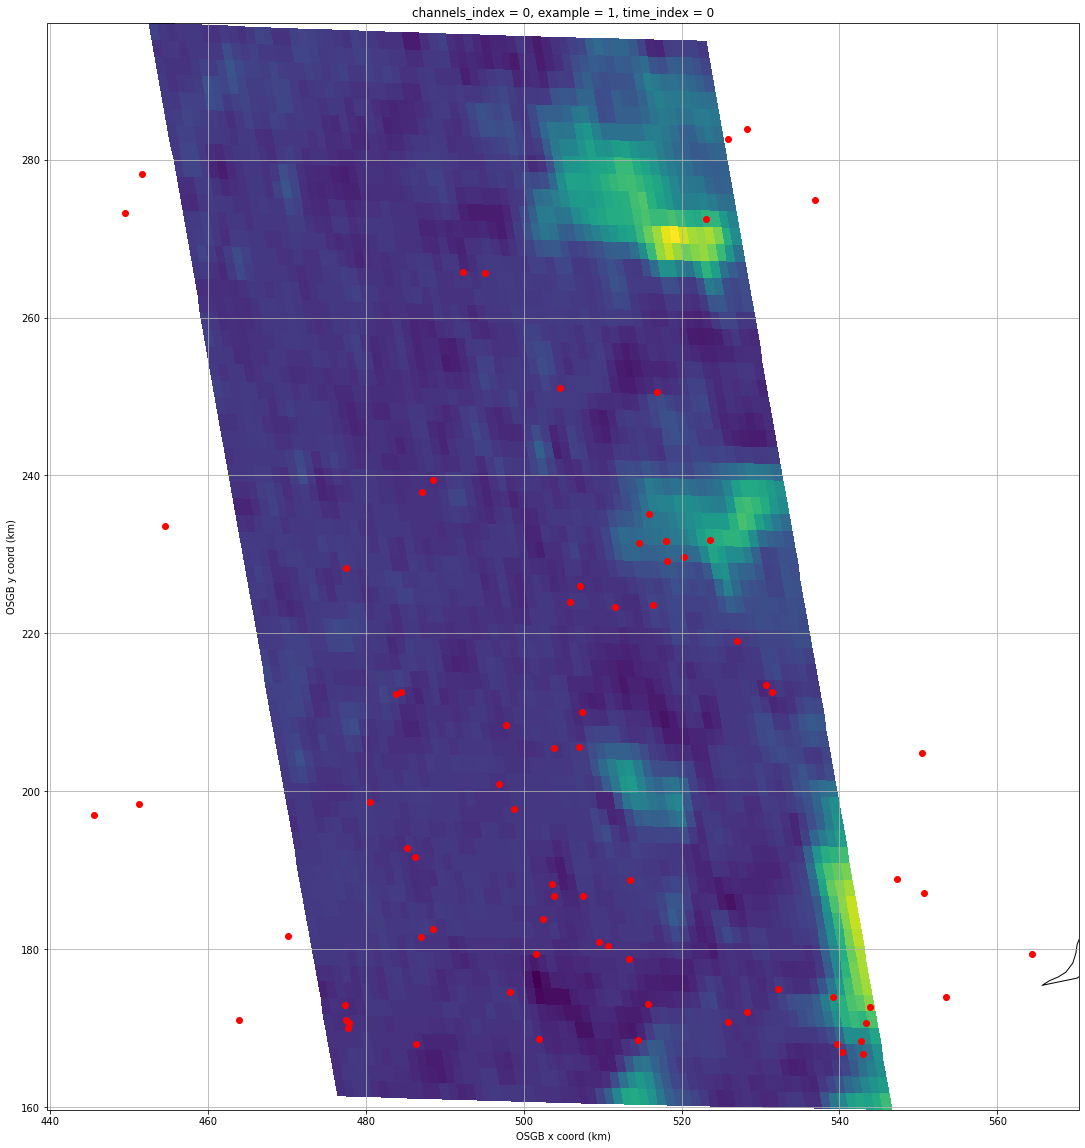

In [69]:
EXAMPLE_I = 1
ax = plt.axes(projection=ccrs.OSGB(approx=False))

# Plot HRV
hrv_batch["data"].sel(channels_index=0, example=EXAMPLE_I, time_index=0).plot.pcolormesh(
    ax=ax,
    transform=ccrs.OSGB(approx=False),
    y="y_osgb",
    x="x_osgb",
    add_colorbar=False,

)

# Plot PV locations
pv_locations = pv_batch[["x_coords", "y_coords"]].sel(example=EXAMPLE_I)
valid_pv_id_mask = np.nonzero(pv_locations.x_coords.values)
ax.scatter(
    x=pv_locations.x_coords[valid_pv_id_mask],
    y=pv_locations.y_coords[valid_pv_id_mask],
    color="red"
)

ax.coastlines()
#ax.set_global()
for axis in (ax.xaxis, ax.yaxis):
    axis.set_visible(True)
    axis.set_major_formatter(ticker.FuncFormatter(lambda x, d: f"{x/1000:.0f}"))
ax.set_ylabel("OSGB y coord (km)")
ax.set_xlabel("OSGB x coord (km)")
ax.grid()

Select PV systems which are towards the upper-middle of the satellite imagery.